In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer
import nltk
from nltk.tokenize import RegexpTokenizer
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import BayesianRidge, SGDRegressor, ElasticNet


In [2]:
# read the data
data_df = pd.read_csv('data.csv')
data_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   class     1000 non-null   object 
 1   value     1000 non-null   float64
 2   distance  1000 non-null   int64  
 3   special   1000 non-null   bool   
dtypes: bool(1), float64(1), int64(1), object(1)
memory usage: 24.5+ KB


**Problem 3 - Exploratory Analysis of "data.csv"**

**Used plots and statistics to analyze the data provided in data.csv file.**

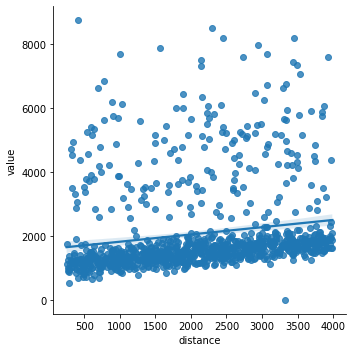

In [3]:
# plot the "distance" vs "value" to find their relationship
sns.lmplot(x='distance', y='value', data=data_df)

**It can be seen that there is a linear relationship between 
distance and value. The regression line is slightly above the location
of majority of the data points due to the presence of several high-valued outliers.**

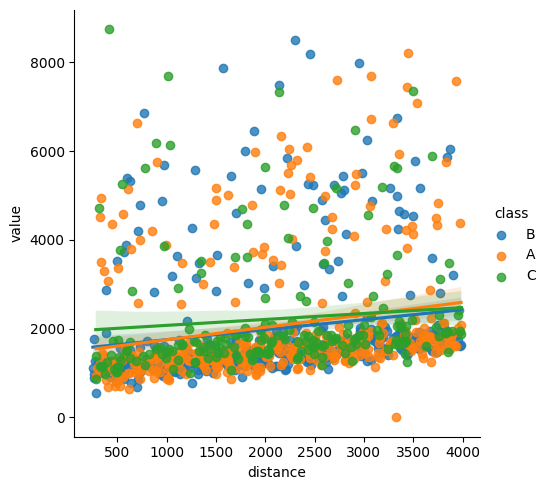

In [4]:
# Plot the distance vs value data as a function of class labels
sns.lmplot(x = 'distance', y = 'value', data=data_df, hue='class')

**From the figures it can be seen that there is not much difference betewen the data from the three classes.**

**Below, we test this observation with the null hypothesis that there is no significant difference between the means/medians of value and means/medians of distance across the three classes at significance level of 0.05.**

In [5]:
# Confirm the observation from the above figure using statistics
# create a different dataframe for each class
data_dfA = data_df.loc[data_df['class']=='A'].reset_index(drop=True)
data_dfB = data_df.loc[data_df['class']=='B'].reset_index(drop=True)
data_dfC = data_df.loc[data_df['class']=='C'].reset_index(drop=True)

# First verify the normality of data
F1, p1 = stats.shapiro(data_dfA['distance'])
F2, p2 = stats.shapiro(data_dfA['value'])
F3, p3 = stats.shapiro(data_dfB['distance'])
F4, p4 = stats.shapiro(data_dfB['value'])
F5, p5 = stats.shapiro(data_dfC['distance'])
F6, p6 = stats.shapiro(data_dfC['value'])
print("p1: {}, p2: {}, p3: {}, p4: {}, p5: {}, p6: {}".format(p1, p2, p3, p4, p5, p6))
# The data for both "distance" and "value" are not normally distributed as all the p-values are << 0.05.

# Check for the homogeneity of variances
F1, p1 = stats.levene(data_dfA['distance'], data_dfB['distance'], data_dfC['distance'])
F2, p2 = stats.levene(data_dfA['value'], data_dfB['value'], data_dfC['value'])
print("p1: {}, p2: {}".format(p1, p2))
# The levene test suggests that the both variables have equal variances as p-value >> 0.05.

# Since the data is not normally distributed, we use kruskal-wallis test with the null hypotheses 
# that there is no significant difference in the medians of the "value" data and the medians of the "distance"
# data between the three classes.
F1, p1 = stats.kruskal(data_dfA['value'], data_dfB['value'], data_dfC['value'])
F2, p2 = stats.kruskal(data_dfA['distance'], data_dfB['distance'], data_dfC['distance'])
print("p-value of value: {}, p-value of distance: {}".format(p1, p2))


p1: 5.5745053018085855e-09, p2: 4.842213741818814e-26, p3: 1.639259283869876e-09, p4: 8.839097850223995e-28, p5: 5.312990106176585e-05, p6: 1.8979211960510559e-19
p1: 0.7109858259492337, p2: 0.7337349116737693
p-value of value: 4.0599995731627355e-06, p-value of distance: 0.7364662871436889


**As can be observed from the kruskal-wallis test results, there is statistically significant difference between the medians of the "value" data (p << 0.05) between the three classes. However, there is no such difference in the medians of the "distance" data (p >> 0.05).**

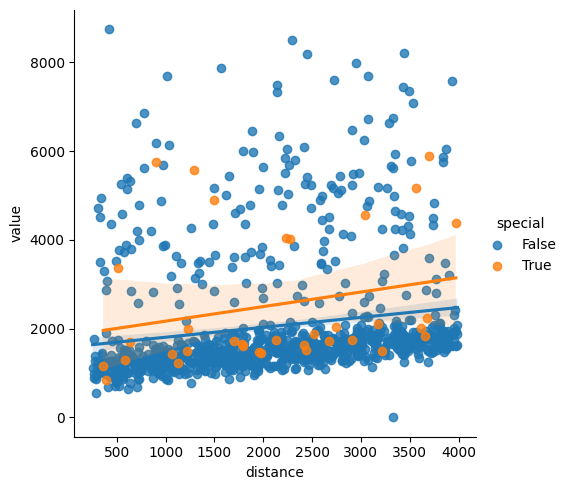

In [6]:
# plot the distance vs value as a function of "special" feature.
sns.lmplot(x = 'distance', y = 'value', data = data_df, hue = 'special')

**Here we can observe significant difference between the regression lines 
for the two special labels.** 

**We will test this observation using independent two-tailed t-test with a null hypothesis that 
there is no significant difference between the means of value and means 
of distance across the two special labels.**

In [7]:
# Split the data between the two labels of special
data_dfT = data_df.loc[data_df['special']==True].sample(frac=1).reset_index(drop=True)
data_dfF = data_df.loc[data_df['special']==False].sample(frac=1).reset_index(drop=True)
    
# First verify the normality of data
F1, p1 = stats.shapiro(data_dfT['distance'])
F2, p2 = stats.shapiro(data_dfT['value'])
F3, p3 = stats.shapiro(data_dfF['distance'])
F4, p4 = stats.shapiro(data_dfF['value'])
print("p1: {}, p2: {}, p3: {}, p4: {}".format(p1, p2, p3, p4))
# Only he data for "distance" from True label are normally distributed (p > 0.05) and all other data 
# are not normally distributed (p << 0.05).

# Check for the homogeneity of variances
F1, p1 = stats.levene(data_dfT['distance'], data_dfF['distance'])
F2, p2 = stats.levene(data_dfT['value'], data_dfF['value'])
print("p1: {}, p2: {}".format(p1, p2))
# The levene test suggests that the both variables have equal variances (p >> 0.05).

# Based on the results from the above two tests we use Mann Whitney U test
# for comparing the medians of "value" and medians of "distance".

F1, p1 = stats.mannwhitneyu(data_dfT['distance'], data_dfF['distance'])
F2, p2 = stats.mannwhitneyu(data_dfT['value'], data_dfF['value'])
print("p-value of distance: {}, p-value of value: {}".format(p1, p2))

p1: 0.16495507955551147, p2: 9.49115383264143e-06, p3: 1.6498472806510188e-15, p4: 2.2106183923956152e-39
p1: 0.9517036894787138, p2: 0.20973933453332336
p-value of distance: 0.9660225468238512, p-value of value: 0.004779232716108615


**The results suggest that there is significant difference in the medians of "value" (p << 0.05) but not between the medians of "distance" (p >> 0.05)**.

**In summary, It can be observed that the medians of "value" significantly differ with both "class" and "special".**

**Problem 1 - Partitioning the data**

**I have satisfied 5 out of the 6 constraints suggested in the problem. They are constraints 1, 2, 3, 4, and 6.**

In [8]:
# function to partition the data into train and test sets
def data_partition(data_df, n_partitions):
    # create a different dataframe for each class and randomly shuffle them
    # satisfies constraint 6
    data_dfA = data_df.loc[data_df['class']=='A'].sample(frac=1).reset_index(drop=True)
    data_dfB = data_df.loc[data_df['class']=='B'].sample(frac=1).reset_index(drop=True)
    data_dfC = data_df.loc[data_df['class']=='C'].sample(frac=1).reset_index(drop=True)
    
    # number of rows in each partition
    rowsA = data_dfA.shape[0] // n_partitions
    rowsB = data_dfB.shape[0] // n_partitions
    rowsC = data_dfC.shape[0] // n_partitions
    
    # create the partitions
    partitions = []
    # satisfies constraint 1
    for i in range(n_partitions):
        if i != n_partitions-1:
            partitions.append(pd.concat([data_dfA.iloc[i*rowsA:(i+1)*rowsA], data_dfB.iloc[i*rowsB:(i+1)*rowsB], data_dfC.iloc[i*rowsC:(i+1)*rowsC]], axis=0, ignore_index=True))
        else:
            partitions.append(pd.concat([data_dfA.iloc[i*rowsA:], data_dfB.iloc[i*rowsB:], data_dfC.iloc[i*rowsC:]], axis=0, ignore_index=True))
    
    return tuple(partitions)
    

In [9]:
# testing the partition data function by dividing the data into three partitions
data1, data2, data3 = data_partition(data_df, 3)
# constraint 2
print(data1.shape, data2.shape, data3.shape)
# constraint 3
print(data1.groupby(['class']).size(), data2.groupby(['class']).size(), data3.groupby(['class']).size())
# constraint 4
print(data1['value'].sum(), data2['value'].sum(), data3['value'].sum())

(333, 4) (333, 4) (334, 4)
class
A    130
B    134
C     69
dtype: int64 class
A    130
B    134
C     69
dtype: int64 class
A    130
B    135
C     69
dtype: int64
701649.3300000001 699253.49 669935.9200000002


**Problem 2 - Predicting "value" with a machine learning or statistic model**

In [10]:
# obtain the train and test data
train_data, test_data = data_partition(data_df, 2)

In [11]:
# testing constraint 2
print("train data shape: {}, test data shape: {}".format(train_data.shape, test_data.shape))

train data shape: (499, 4), test data shape: (501, 4)


In [12]:
# testing constraint 3
print("train data classes: {}, test data classes: {}".format(train_data.groupby(['class']).size(), test_data.groupby(['class']).size()))
      

train data classes: class
A    195
B    201
C    103
dtype: int64, test data classes: class
A    195
B    202
C    104
dtype: int64


In [13]:
# testing constraint 4
print("train data value sum: {}, test data value sum: {}".format(train_data['value'].sum(), test_data['value'].sum()))

train data value sum: 1029684.9199999999, test data value sum: 1041153.8200000001


In [14]:
# split the train and test data into features and targets
# since the "value" is dependent on all the three features based 
# on the exploratory data analysis, we use "class", "distance", and "special"
# as features. We use "value" as the target.
y_train = train_data[['value']]
x_train = train_data.drop('value', axis=1)
y_test = test_data[['value']]
x_test = test_data.drop('value', axis = 1)

In [15]:
# use standard scaler for the "distance metric" and 
# one hot encoder for the two categorical features (class and special)
numerical_features = ["distance"]
numerical_transformer = StandardScaler()
categorical_features = ["class", "special"]
categorical_transformer = OneHotEncoder()
# use a column transformer for the two encoders
preprocessor = ColumnTransformer(
                    transformers=[
                        ("num", numerical_transformer, numerical_features),
                        ("cat", categorical_transformer, categorical_features),
                    ]
                    )
# combine the preprocessing encoder with a Linear regressor into a pipeline
pipe = Pipeline(steps = [('Preprocessor', preprocessor), ('Regressor', LinearRegression())])
# fit the training data
pipe.fit(x_train, y_train)
# score the test data
pipe.score(x_test, y_test)

0.035697045739371935

**As can be seen from the correlation coefficient 
obtained from the score function on the test dataset, 
the accuracy is very less. That is mainly due to the presence of
large-valued outliers in the "value" data.**

In [16]:
# To see if a more complicated regressor model will improve the accuracy,
# I also tried several other standard regression models. 
# However, none of them gave any better accuracy than linear regressor.
# combine the preprocessing encoder with a Linear regressor into a pipeline
pipe2 = Pipeline(steps = [('Preprocessor', preprocessor), ('Regressor', KernelRidge())])
# fit the training data
pipe2.fit(x_train, y_train)
# score the test data
pipe2.score(x_test, y_test)

0.03570929276173507

In [17]:
# obtain the predictions from the Linear Regressor on the test data.
y_pred = pipe.predict(x_test)

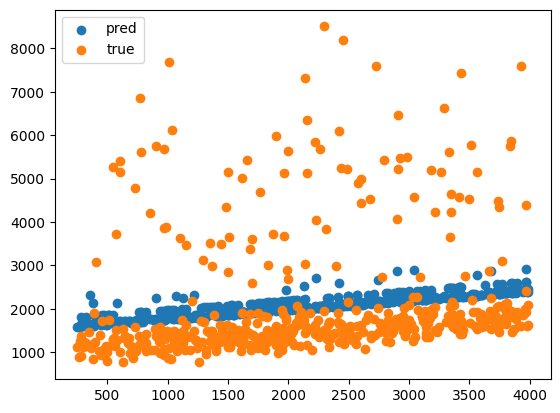

In [18]:
plt.scatter(x_test['distance'], y_pred, label="pred")
plt.scatter(x_test['distance'], y_test, label="true")
plt.legend(loc="upper left")

**As can be observed from the above plot, the predicted values are 
slightly above the majority of the true values similar to the observation from
the regression line in exploratory data analysis.**

**Problem 4 - Bigrams**

**I used the nltk library in python to generate bigrams
given a paragraph.**

In [19]:
paragraph = """
Machine learning is about extracting knowledge from data.
It is a research field at the intersection of statistics, 
artificial integlligence and computer science.
"""


In [20]:
def Bigram_model(paragraph):
    # remove punctuation while computing bigrams
    tokenizer = RegexpTokenizer(r'\w+')
    return list(nltk.bigrams(tokenizer.tokenize(paragraph.lower())))

print(Bigram_model(paragraph))

[('machine', 'learning'), ('learning', 'is'), ('is', 'about'), ('about', 'extracting'), ('extracting', 'knowledge'), ('knowledge', 'from'), ('from', 'data'), ('data', 'it'), ('it', 'is'), ('is', 'a'), ('a', 'research'), ('research', 'field'), ('field', 'at'), ('at', 'the'), ('the', 'intersection'), ('intersection', 'of'), ('of', 'statistics'), ('statistics', 'artificial'), ('artificial', 'integlligence'), ('integlligence', 'and'), ('and', 'computer'), ('computer', 'science')]


**Problem 5 - Triplets**

**I sorted the input first which takes O(nlogn) complexity
before obtaining the triplets.**

In [21]:
def ThreeSum(nums):
    # output variable
    out = []
    # sort the list in ascending order
    nums.sort()
    # length of nums 
    n = len(nums)
    # go through the sorted list
    for i in range(n-2):
        # If the number at index i is different from the number at index i-1
        if i == 0 or nums[i] != nums[i-1]:
            j = i+1    # start with the next index
            k = n-1    # start with the last index
            while j < k:   # while the index j is less than index k
                sum3 = nums[i] + nums[j] + nums[k] # compute the three sum
                if sum3 == 0:   # If the sum is zero, append the three numbers to the out list
                    out.append([nums[i], nums[j], nums[k]])
                    while j < k and nums[j] == nums[j+1]:  # Ignore the duplicates
                        j += 1
                    j += 1  # Proceed to the next index in the ascending order
                    
                    while j < k and nums[k] == nums[k-1]:   # Ignore the duplicates
                        k -= 1
                    k -= 1  # Proceed to the next index in the descending order
                
                elif sum3 < 0:   # If the sum3 is less than zero, increase the j index in the sorted list
                    j +=1
                
                else:        # If the sum3 is greater than zero, decrease the k index in the sorted list
                    k -= 1
    return out

In [22]:
nums1 = [0, 0, 0]
nums2 = [0, 1, 1]
nums3 = [-1, 0, 1, 2, -1, -4]
nums = nums3
out = ThreeSum(nums)
print(out)

[[-1, -1, 2], [-1, 0, 1]]


**Problem 6 - Your Python Enviroment**

**To run this notebook in any computer just like in my computer,
I created a Docker container using the necessary requirements.txt file.**